In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.13.0


In [3]:
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):
 

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['pomegranate' 'carrot' 'garlic' 'tomato' 'kiwi' 'ginger' 'sweetpotato'
 'soy beans' 'lemon' 'paprika' 'apple' 'mango' 'banana' 'beetroot'
 'lettuce' 'corn' 'potato' 'pineapple' 'grapes' 'watermelon' 'onion'
 'spinach' 'capsicum' 'turnip' 'cabbage' 'eggplant' 'chilli pepper'
 'jalepeno' 'pear' 'cauliflower' 'cucumber' 'bell pepper' 'sweetcorn'
 'raddish' 'peas' 'orange']


In [9]:
train_df.head(5)

,Filepath,Label
0,../input/fruit-and-vegetable-image-recognition...,pomegranate
1,../input/fruit-and-vegetable-image-recognition...,carrot
2,../input/fruit-and-vegetable-image-recognition...,garlic
3,../input/fruit-and-vegetable-image-recognition...,tomato
4,../input/fruit-and-vegetable-image-recognition...,kiwi


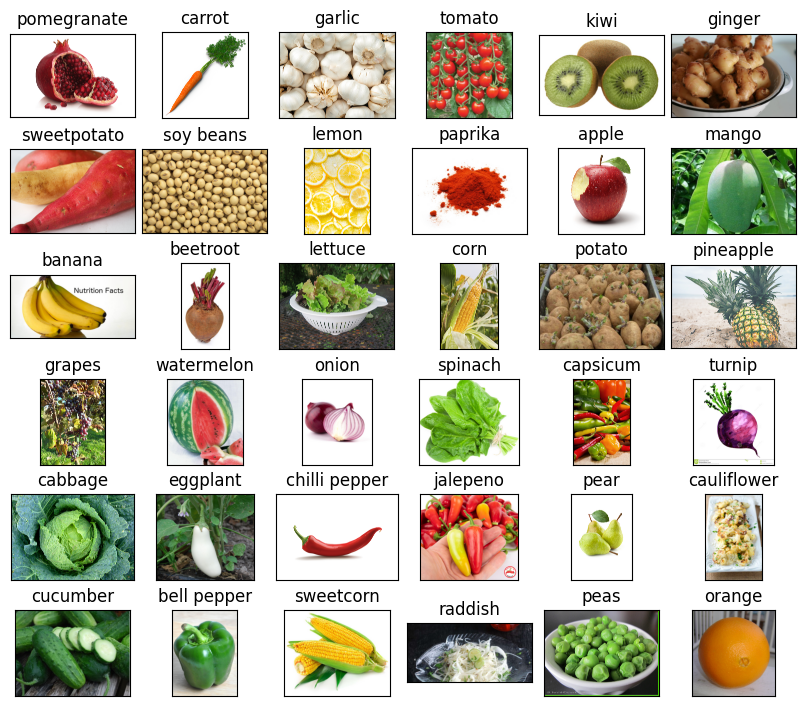

In [10]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [15]:
weights_path = '/kaggle/input/datamodel/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=weights_path,  # Load ImageNet weights from the Kaggle dataset
    pooling='avg'
)

pretrained_model.trainable = False

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 146s 2s/step - loss: 1.8279 - accuracy: 0.5126 - val_loss: 0.5143 - val_accuracy: 0.8533
Epoch 2/5
87/87 [==============================] - 128s 1s/step - loss: 0.5953 - accuracy: 0.8108 - val_loss: 0.3183 - val_accuracy: 0.8802
Epoch 3/5
87/87 [==============================] - 128s 1s/step - loss: 0.3670 - accuracy: 0.8770 - val_loss: 0.2433 - val_accuracy: 0.9341
Epoch 4/5
87/87 [==============================] - 125s 1s/step - loss: 0.2396 - accuracy: 0.9216 - val_loss: 0.1747 - val_accuracy: 0.9611
Epoch 5/5
87/87 [==============================] - 126s 1s/step - loss: 0.1538 - accuracy: 0.9532 - val_loss: 0.1561 - val_accuracy: 0.9611


In [18]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 18s 1s/step


['spinach',
 'lettuce',
 'bell pepper',
 'paprika',
 'pomegranate',
 'turnip',
 'grapes',
 'lettuce',
 'onion',
 'beetroot',
 'eggplant',
 'lemon',
 'cucumber',
 'pineapple',
 'jalepeno',
 'pineapple',
 'bell pepper',
 'paprika',
 'eggplant',
 'beetroot',
 'mango',
 'watermelon',
 'kiwi',
 'mango',
 'potato',
 'banana',
 'carrot',
 'spinach',
 'chilli pepper',
 'onion',
 'cucumber',
 'peas',
 'turnip',
 'cucumber',
 'tomato',
 'potato',
 'onion',
 'pear',
 'chilli pepper',
 'raddish',
 'orange',
 'spinach',
 'turnip',
 'cucumber',
 'raddish',
 'lettuce',
 'garlic',
 'ginger',
 'mango',
 'kiwi',
 'garlic',
 'sweetpotato',
 'jalepeno',
 'kiwi',
 'lettuce',
 'sweetcorn',
 'carrot',
 'chilli pepper',
 'corn',
 'raddish',
 'watermelon',
 'tomato',
 'pomegranate',
 'kiwi',
 'paprika',
 'turnip',
 'onion',
 'soy beans',
 'jalepeno',
 'mango',
 'corn',
 'peas',
 'bell pepper',
 'pomegranate',
 'ginger',
 'spinach',
 'soy beans',
 'onion',
 'ginger',
 'bell pepper',
 'peas',
 'paprika',
 'water

In [19]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [20]:
img = output('../input/fruit-and-vegetable-image-recognition/test/banana/Image_1.jpg')
img

1/1 [==============================] - 1s 1s/step


'banana'

In [34]:
import requests
import json

api_url = 'https://api.api-ninjas.com/v1/nutrition?query={}'.format(img)
response = requests.get(api_url, headers={'X-Api-Key': 'FJCuuMBu83nEaI7CGroR8A==z88oB9CslsPk9p80'})
if response.status_code == requests.codes.ok:
    employee_string = response.text
    json_object = json.loads(employee_string)
    print(json.dumps(json_object[0], indent=4))
else:
    print("Error:", response.status_code, response.text)
    


{
    "name": "banana",
    "calories": 89.4,
    "serving_size_g": 100.0,
    "fat_total_g": 0.3,
    "fat_saturated_g": 0.1,
    "protein_g": 1.1,
    "sodium_mg": 1,
    "potassium_mg": 22,
    "cholesterol_mg": 0,
    "carbohydrates_total_g": 23.2,
    "fiber_g": 2.6,
    "sugar_g": 12.3
}


In [36]:
model.save('Team1.h5')

In [42]:
import streamlit as st
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.models import load_model
import requests
from bs4 import BeautifulSoup

In [43]:
model = load_model('Team1.h5')

In [45]:
labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

fruits = ['Apple', 'Banana', 'Bello Pepper', 'Chilli Pepper', 'Grapes', 'Jalepeno', 'Kiwi', 'Lemon', 'Mango', 'Orange',
          'Paprika', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon']
vegetables = ['Beetroot', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Corn', 'Cucumber', 'Eggplant', 'Ginger',
              'Lettuce', 'Onion', 'Peas', 'Potato', 'Raddish', 'Soy Beans', 'Spinach', 'Sweetcorn', 'Sweetpotato',
              'Tomato', 'Turnip']

In [47]:
import streamlit as st
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.models import load_model
import requests
import json

model = load_model('FV.h5')

labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

def fetch_calories(product_name):
    api_url = 'https://api.api-ninjas.com/v1/nutrition?query={}'.format(product_name)
    response = requests.get(api_url, headers={'X-Api-Key': 'FJCuuMBu83nEaI7CGroR8A==z88oB9CslsPk9p80'})
    
    if response.status_code == requests.codes.ok:
        nutrition_info = json.loads(response.text)
        return nutrition_info[0]  # Возвращает информацию о питательных веществах в формате JSON
    else:
        return None

def processed_img(img_path):
    img = load_img(img_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res.capitalize()

def run():
    st.title("Fruits🍍-Vegetable🍅 Classification")
    img_file = st.file_uploader("Choose an Image", type=["jpg", "png"])
    
    if img_file is not None:
        img = Image.open(img_file).resize((250, 250))
        st.image(img, use_column_width=False)
        
        save_image_path = './upload_images/' + img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())
            
        result = processed_img(save_image_path)
        
        if result in vegetables:
            st.info('**Category : Vegetables**')
        else:
            st.info('**Category : Fruit**')
        
        st.success("**Predicted : " + result + '**')
        
        calories_info = fetch_calories(result)
        
        if calories_info:
            st.warning('**' + json.dumps(calories_info, indent=4) + '**')
        else:
            st.error('Error fetching nutrition information.')

run()
